# Brevísimo análisis del COVID-19

Fuente de donde se obtuvieron los datos: [Repositorio de John Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19)

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
datos = pd.read_csv("time_series_covid19_confirmed_global.csv")
datos = datos.groupby("Country/Region").agg("sum")

paises = datos.index
fechas = datos.columns[2:]

1. **Graficar al menos 10 países, origen común**

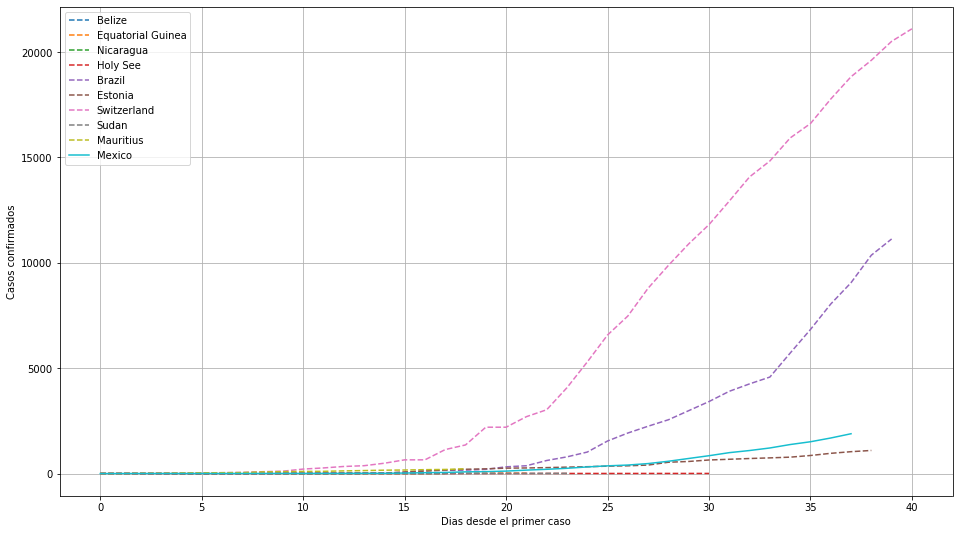

In [48]:
plt.figure(figsize=(16,9))

unos_paises = list(np.random.choice(paises,9)) + ["Mexico"]
for pais in unos_paises:
    datos_pais = datos.loc[pais,fechas]
    datos_pais = datos_pais[datos_pais > 0]
    n = len(datos_pais)
    x = np.arange(n)
    if pais != "Mexico":
        estilo = "--"
    else:
        estilo = "-"
    plt.plot(x,datos_pais,label=pais,ls=estilo)

plt.xlabel("Dias desde el primer caso")
plt.ylabel("Casos confirmados")
plt.legend()
plt.grid()
plt.show()

2. **Elegir un país y ajustar el modelo exponencial que se muestra**

Definimos a
* $I_i$ como el número de casos confirmados en el día i
* $\Delta I_i$ como la diferencia de casos confirmados entre el día $i-1$ y $i$

Se realiza la suposición de que los casos confirmados de un día es proporcional a los casos confirmados del día 
anterior

$$
\Delta I_n = I_{n-1}E \\
I_n - I_{n-1} = I_{n-1}E \\
I_n = I_{n-1}E + I_{n-1} \\
I_n = I_{n-1}(E+1)
$$

Resolviendo la ecuación de recurrencia se tiene que
$$I_n = I_0(E+1)^n$$
Donde $I_0$ son los casos confirmados del día 0

En general
$$
I_n = I_s(E+1)^{n-s}
$$


### Haciendo la regresión
Vemos que la ecuación anterior tiene la forma $y^* = ab^x$

Manipulando con logaritmos
$$
\log y^* = \log(ab^x)\\
\log y^* = \log(a) + \log(b)x
$$

La última ecuación tiene la forma de la linea donde
* $\log y^* = y$
* $\log a = \beta_0$
* $\log b = \beta_1$

por lo que el problema que tenemos que resolver es de regresión lineal con datos $(x,\log y)$

Ahora...
* $y^* = I_n$
* $a = I_0$
* $b = (E+1)$

In [49]:
from sklearn.linear_model import LinearRegression

class ExponentialRegression:
    def __init__(self):
        self.X = None
        self.y = None
        self.a = None
        self.b = None
        self.model = None
        
    def fit(self,X,y):
        if X.ndim == 1:
            X = X.reshape(-1,1)
        self.X = X
        self.y = y
        
        modelo_lineal = LinearRegression().fit(X,np.log(y))
        self.model = modelo_lineal
        self.a = np.exp(modelo_lineal.intercept_)
        self.b = np.exp(modelo_lineal.coef_[0])
        
        return self
    
    def predict(self,X):
        return self.a*np.power(self.b,X)
    
    def score(self,X,y):
        if X.ndim == 1:
            X = X.reshape(-1,1)
        return self.model.score(X,np.log(y))

Valor de E = 0.225487562475847


Text(0.5, 1.0, 'Casos confirmados en México')

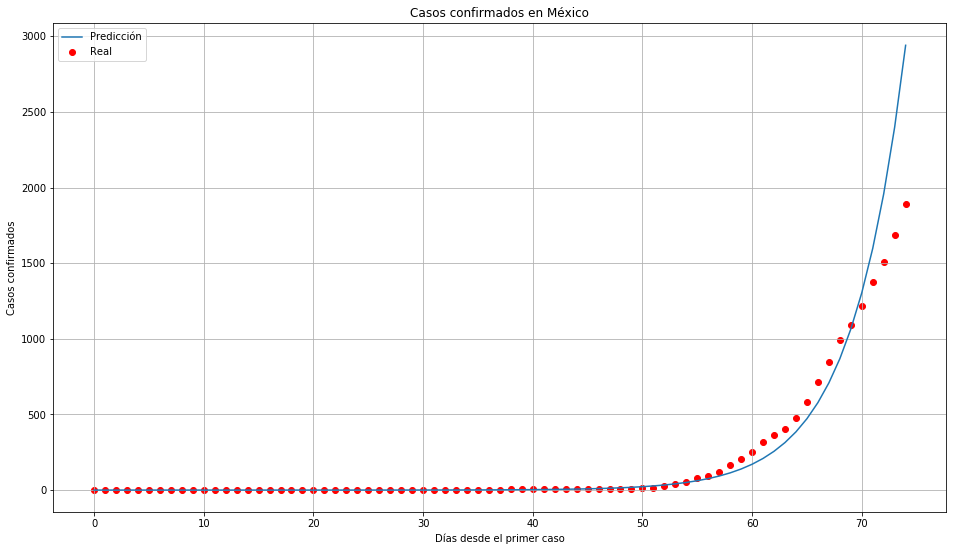

In [59]:
datos_mexico = datos.loc["Mexico",fechas]
dias_sin_casos = (datos_mexico == 0).sum()
desfase = dias_sin_casos + 0 # El último es para cambiar

ncasos_mexico = datos_mexico[datos_mexico>0].values

fecha2int = {fecha:i for i,fecha in enumerate(fechas)}
int2fechas = {i:fecha for i,fecha in enumerate(fechas)}
dias = fechas.map(fecha2int).values

me = ExponentialRegression().fit(dias[desfase:],datos_mexico[desfase:])

print(f"Valor de E = {me.b - 1}")

plt.figure(figsize=(16,9))
plt.scatter(dias,datos_mexico.values, label="Real",c='red')
plt.plot(dias,me.predict(dias), label="Predicción")
plt.legend()
plt.grid()
plt.xlabel("Días desde el primer caso")
plt.ylabel("Casos confirmados")
plt.title("Casos confirmados en México")

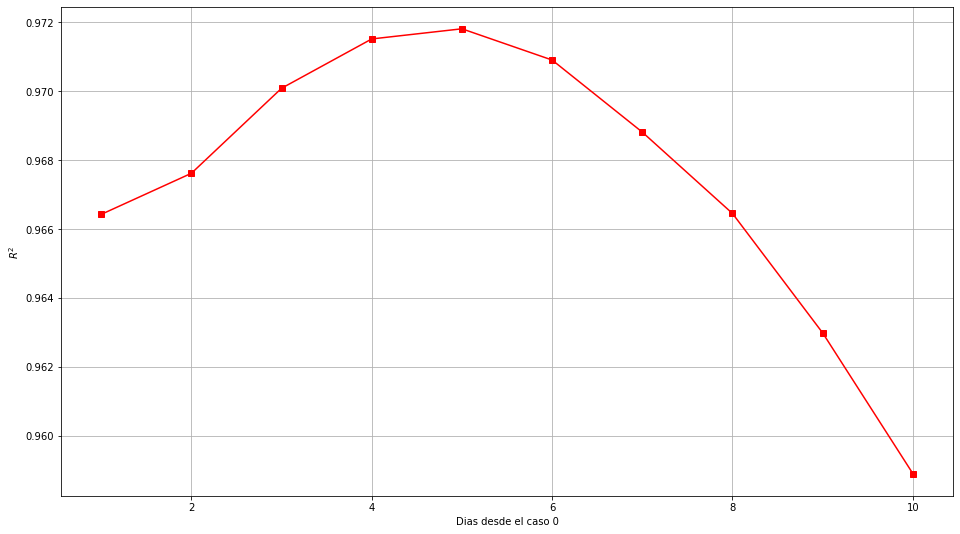

In [51]:
offsets = [1,2,3,4,5,6,7,8,9,10]
scores = []
for offset in offsets:
    desfase = dias_sin_casos + offset
    me = ExponentialRegression().fit(dias[desfase:],datos_mexico[desfase:])
    scores.append(me.score(dias[desfase:],datos_mexico[desfase:]))

plt.figure(figsize=(16,9))
plt.plot(offsets,scores,marker='s',c="r")
plt.xlabel("Dias desde el caso 0")
plt.ylabel("$R^2$")
plt.grid()
plt.show()

Apreciamos que el modelo en general es muy bueno. No considerar ciertos días podría ser causa de sobreajuste, puesto que se estarían considerando menos datos.

De cualquier manera, el modelo se ajusta mejor a partir de 5 días desde el primer caso

**Bonus**

$$
I_n = \frac{P}{1+ (P-1)e^{-kn} }
$$

Donde P es la población de México

Nada mas necesitamos la k

$$
k = -\frac{\ln \left( \frac{1}{P-1}\left[\frac{P}{I_n} - 1\right] \right)}{n}
$$

In [60]:
def I_n(n,k,p):
    a = (p-1)/p
    denominador = 1+(p-1)*np.exp(-k*n)
    return p/denominador

In [61]:
def obtener_k(n,I,P):
    num = (1/(P-1))*(P/I - 1)
    return -np.log(num)/n

In [96]:
casos_mexico = datos_mexico[datos_mexico>0]

P = 126*10**6

n = np.arange(len(casos_mexico))
ks = obtener_k(n,casos_mexico,P)
k = ks[-3] # La mejor constante que ajusta a los datos

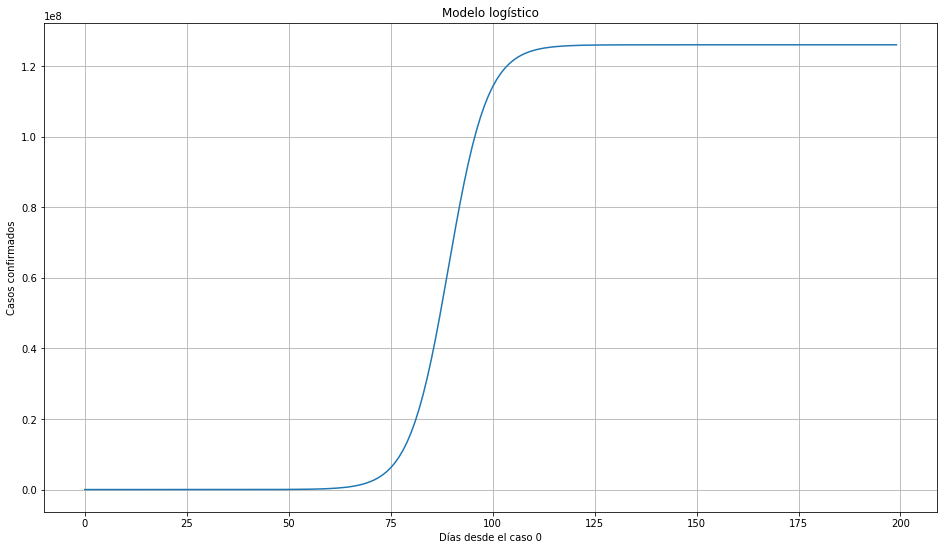

In [105]:
ns = np.arange(0,200)
plt.figure(figsize=(16,9))
plt.plot(ns,I_n(ns,k,P))
plt.title("Modelo logístico")
plt.xlabel("Días desde el caso 0")
plt.ylabel("Casos confirmados")
plt.grid()
plt.show()

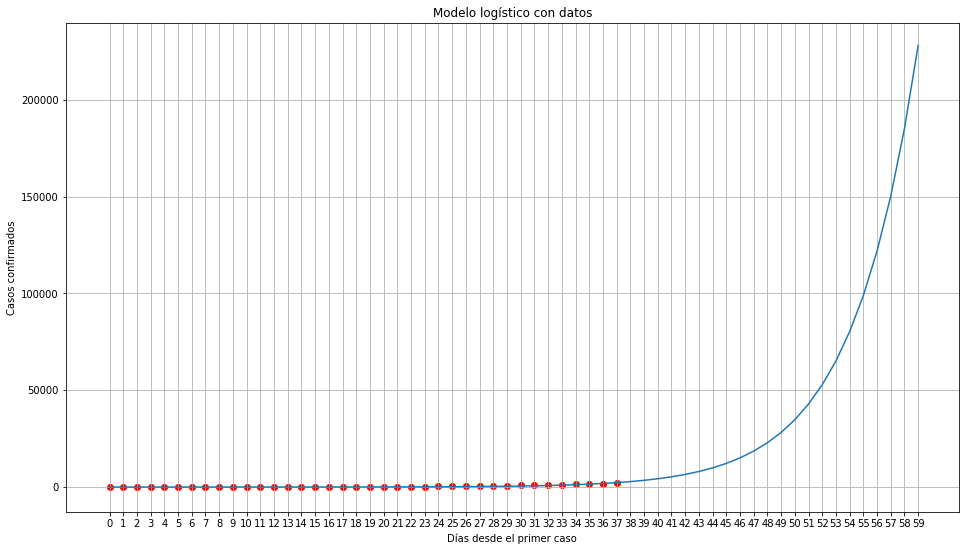

In [108]:
ns = np.arange(0,60)
plt.figure(figsize=(16,9))
plt.plot(ns,I_n(ns,k,P),label="predicción")
plt.scatter(n,casos_mexico,c="red",label="Real")
plt.xticks(ns)
plt.xlabel("Días desde el primer caso")
plt.ylabel("Casos confirmados")
plt.title("Modelo logístico con datos")
plt.grid()
plt.show()



In [107]:
from sklearn.metrics import r2_score
r2_score(casos_mexico,I_n(ns[:38],k,P))

0.921056565331855